<a href="https://colab.research.google.com/github/ikram-hamizi/AML-DS-2021/blob/main/AML_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Week 4: Reccurent Neural Networks (LSTM, GRU, ATTENTION, Transformer, BERT)

```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Simple and staked LSTM
2. Transformer based models
3. Homework 1 presentation
4. Lab Task
```

<hr>

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import pandas as pd
import numpy as np

# Preliminaries for processing the text
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torchtext
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Prepare the data

In [ ]:
!pip install wget 
import wget 

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=d7e9483e1d2378a4eb1a993783d8b4b9b4630847da220e68c7d27edbca4012fc
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
#Download and unzip dataset
wget.download("http://alt.qcri.org/semeval2016/task6/data/uploads/stancedataset.zip")

!unzip stancedataset.zip

Archive:  stancedataset.zip
   creating: StanceDataset/
  inflating: StanceDataset/test.csv  
   creating: __MACOSX/
   creating: __MACOSX/StanceDataset/
  inflating: __MACOSX/StanceDataset/._test.csv  
  inflating: StanceDataset/train.csv  
  inflating: __MACOSX/StanceDataset/._train.csv  


In [ ]:
#Read dataset to dataframe

train_data = pd.read_csv("StanceDataset/train.csv", header=0, engine='python' ,encoding = "latin-1", usecols=["Tweet","Target"])
test_data = pd.read_csv("StanceDataset/test.csv", header=0, engine='python' ,encoding = "latin-1", usecols=["Tweet","Target"])

test_data.query("Target != 'Donald Trump'",inplace=True)

labels_keys = {value: i for i, (value, count) in enumerate(train_data.Target.value_counts().items())}

train_data['Target'] = train_data['Target'].apply(lambda x: labels_keys.get(x))
test_data['Target'] = test_data['Target'].apply(lambda x: labels_keys.get(x))

In [ ]:
train_data.tail()

,Tweet,Target
2909,"There's a law protecting unborn eagles, but no...",2
2910,I am 1 in 3... I have had an abortion #Abortio...,2
2911,How dare you say my sexual preference is a cho...,2
2912,"Equal rights for those 'born that way', no rig...",2
2913,#POTUS seals his legacy w/ 1/2 doz wins. The #...,2


In [ ]:
print(labels_keys)

{'Hillary Clinton': 0, 'Feminist Movement': 1, 'Legalization of Abortion': 2, 'Atheism': 3, 'Climate Change is a Real Concern': 4}


In [ ]:
test_data.tail()

,Tweet,Target
1244,@MetalheadMonty @tom_six I followed him before...,2
1245,"For he who avenges blood remembers, he does no...",2
1246,Life is sacred on all levels. Abortion does no...,2
1247,"@ravensymone U refer to ""WE"" which =""YOU"" & a ...",2
1248,Al Robertson's mom #DuckDynasty chose life as...,2


In [ ]:
train_data['Target'].unique()

array([0, 2, 3, 4, 1])

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#TODO: preprocess each an every sentence (tweet text)

def clean_data(text):
  #remove non ascii
  text = text.encode("ascii", "ignore").decode()

  # Removing multiple spaces
  text = re.sub(r'\s+', ' ', text)
  
  #remove user handle and hashtags
  text = re.sub(r'(\@|\#)\w+','', text)

  #remove numbers
  text = re.sub(r'[0-9]','', text)

  #remove "RT"
  text = re.sub(r'(rt|RT)','', text)

  #remove stop words 
  text = remove_stopwords(text)
  
  return text

train_data['Tweet'] = train_data['Tweet'].apply(clean_data)
test_data['Tweet'] = test_data['Tweet'].apply(clean_data)

In [ ]:
train_data.tail()

,Tweet,Target
2909,"There's law protecting unborn eagles, humans u...",2
2910,I ... I aboion,2
2911,"How dare sexual preference choice, dare dismem...",2
2912,"Equal rights 'born way', rights born.",2
2913,seals legacy w/ / doz wins. The agenda? STILL!...,2


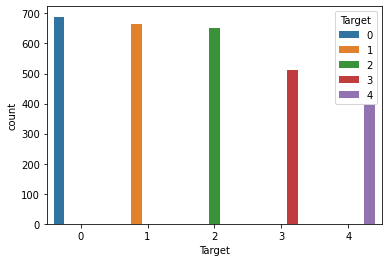

In [ ]:
import seaborn as sns
sns.countplot(x="Target",hue='Target',data=train_data)

In [ ]:
#tokenize and create Vocab
tokenizer = get_tokenizer('basic_english')
counter = Counter()

for _, row in train_data.iterrows():
  counter.update(tokenizer(row["Tweet"]))

vocab = Vocab(counter,specials=("<pad>","<unk>"), min_freq=1)

In [ ]:
# Do padding
def data_process(raw_text_iter,max_len=64):
  batch = []
  for item in raw_text_iter:
    res = [vocab[token] for token in tokenizer(item)]
    if len(res) > max_len : 
      res = res[:max_len]
    if len(res) < max_len :
      res += ([vocab["<pad>"]] * (max_len-len(res)))
    batch.append(res)
  pad_data = torch.tensor(batch, dtype=torch.long)
  return pad_data

In [ ]:
max_len = 64
embedding_size = 10
n_classes = len(np.unique(train_data.Target.values))

#Create Dataloader
train_tensor = data_process(train_data.Tweet.values)
tgts_tensor = torch.nn.functional.one_hot(torch.from_numpy(train_data.Target.values), n_classes) #torch.from_numpy(train_data.Target.values)

dataset = TensorDataset(train_tensor, tgts_tensor)

loader = DataLoader(dataset, batch_size=2, shuffle=True, pin_memory=True)

In [ ]:
m = np.array([2,2])
mt = torch.nn.functional.one_hot(torch.from_numpy(m), n_classes) #torch.from_numpy(train_data.Target.values)


tensor([[0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0]])


## Simple LSTM

In [ ]:
class SimpleLstm(nn.Module):
  def __init__(self, embedding_dim ,vocab_size , hidden_dim=10, output_dim=1, n_layers=1):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers,batch_first = True)
    self.output_layer = nn.Linear(hidden_dim, output_dim)
      
  def forward(self, x):
    batch_size = x.size(0)
    embedded = self.embedding(x)
    outputs, (hidden, cell) = self.lstm_layer(embedded)
    
    pred = self.output_layer(hidden[-1])
    return pred

vocab_size = len(vocab)
embedding_size = 64
output_dim = len(np.unique(train_data['Target']))
model = SimpleLstm(embedding_dim=embedding_size, vocab_size=vocab_size, hidden_dim=10,output_dim=output_dim).to(device).float()

In [ ]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
print(TEXT.pad_token)
print(PAD_IDX)

## Model summary



In [ ]:
print(model)

SimpleLstm(
  (embedding): Embedding(6515, 64)
  (lstm_layer): LSTM(64, 10, batch_first=True)
  (output_layer): Linear(in_features=10, out_features=5, bias=True)
)


## Train Model

In [ ]:
# def one_hot(tensor):
#   onehottensor = torch.nn.functional.one_hot(tensor.to(torch.int64), n_classes) #torch.from_numpy(train_data.Target.values)
#   return onehottensor

In [ ]:
#DONE: Implement Model train function which will return epoch loss and accuracy
import numpy as np

#Returns accuracy per batch
def accuracy_calculator(preds, y):
  pred_softmax = torch.softmax(preds,dim=1)    # Apply sigmoid after fc from model
  _, preds = torch.max(pred_softmax, dim = 1)

  y = torch.argmax(y, axis=1)
  TruePositives_batch = sum(preds == y) #true positives

  accuracy = TruePositives_batch/float(len(preds))
  return accuracy

def train(model, data_loader, optimizer, criterion, device):
  epoch_loss = 0
  epoch_accuracy = 0

  model.train()

  for i, data in enumerate(data_loader, 0): 
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
        
    loss = criterion(outputs.to(device), labels.to(device).float())
    loss.backward()
    optimizer.step()

    acc = accuracy_calculator(outputs, labels)

    epoch_loss += loss.item()
    epoch_accuracy += acc.item()
  return epoch_loss / len(data_loader) , epoch_accuracy / len(data_loader) 

In [ ]:
# Train loop 
criterion = torch.nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(model.parameters(), lr=1e-3)

criterion = criterion.to(device)
n_epochs = 2

for epoch in range(n_epochs):
  train_loss, train_acc = train(model, loader, optimizer, criterion, device=device)
  print(f"Loss : {train_loss}")

Loss : 0.6568274693940712
Loss : 0.6038651123550876


In [ ]:
print(train_acc)

0.23644474948524366


In [ ]:
'''
Loss : 0.6765171545535306
Loss : 0.5912118203319257
'''

## Transformers & Bert

Sentiment analysis task. We are going to use the [transformers library](https://github.com/huggingface/transformers) to get pre-trained transformers and use them as embedding layers. Its possible to implement from scratch. Bert is one of the popular transformer based models, <br>
* **Name other transformer based state-of-the-art models** <br>

The transformers library can be easily installed with pip <br>`pip install transformers`

In [ ]:
!pip install transformers
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

     |████████████████████████████████| 2.2MB 5.4MB/s 
     |████████████████████████████████| 870kB 18.2MB/s 
     |████████████████████████████████| 3.3MB 16.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=5a81079df4b96b2fc0924d6d9c0d468bd878a593a77c0e8559db292906f86755
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses



[CLS] [SEP] [PAD] [UNK]


In [ ]:
def tokenize_and_trim(sentence):
  tokens = tokenizer.tokenize(sentence) 
  tokens = tokens[:max_input_length-2]
  return tokens

In [ ]:
import torch.nn as nn

class BertBasedSentiment(nn.Module):
  def __init__(self, transform_based_model, hidden_dim, output_dim, n_layers, bidirectional, dropout):
    super().__init__()
    self.transform_based_model = transform_based_model

    self.embedding_dim = transform_based_model.config.to_dict()['hidden_size']
    self.gru = nn.GRU(self.embedding_dim, hidden_dim, num_layers = n_layers,bidirectional = bidirectional,batch_first = True,dropout = 0 if n_layers < 2 else dropout)
    self.output_layer = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout)
        
  def forward(self, text):
    # First pass the input text through bert. The output of bert is like embedding Remember: Bert is set to not trainable mode
    with torch.no_grad():
      embed = self.transform_based_model(text)[0]
      
    _, hidden = self.gru(embed)

    if self.gru.bidirectional:
      hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
    else:
      hidden = self.dropout(hidden[-1,:,:])
      
    return self.output_layer(hidden)


In [ ]:
from transformers import BertTokenizer, BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

hidden_dim = 256
out_dim = len(np.unique(train_data['Target']))
bi_directional = True
dropout_rate = 0.25
n_layers = 2

model = BertBasedSentiment(bert_model, hidden_dim, out_dim, n_layers, bi_directional, dropout_rate).to(device).float()

In [ ]:
#Set all the bert weights non-trainable
for name, param in model.named_parameters():
  if name.startswith('bert'):
    param.requires_grad = False

## Train Bert model

First, we will specify the algorithm to update the model we parameters in the training process - optimizer. The most common is stochastic gradient descent (SGD). Secondly, we will specify the loss calculation function which is selected based on the learning objective (regression, classification, ..). Lastly, all the specified algorithms must be placed in the same training device where the model is

In [ ]:
import torch.optim as optim

# TODO: Select the optimizer and loss function/criterion
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
epochs = 5

for epoch in range(epochs):
  train_loss, train_acc = train(model, loader, optimizer, criterion, device)
  print(f"Epoch: {epoch}, Loss :{train_loss}, Accuracy: {train_acc}")

Epoch: 0, Loss :0.5332576487374453, Accuracy: 0.2175703500343171
Epoch: 1, Loss :0.5302240652177296, Accuracy: 0.2083047357584077
Epoch: 2, Loss :0.524814286488495, Accuracy: 0.21551132463967054
Epoch: 3, Loss :0.5247578236671367, Accuracy: 0.22512010981468772
Epoch: 4, Loss :0.5271457652973655, Accuracy: 0.21688400823610157


## Lab Task 

```
1. Write a predict function that takes in a trained net, a plain tweet text and prints out a tweet topic (label).
2. Add make bi-directional LSTM for the classification of tweet topic. (Modify the simple LSTM model example)
3. Create a validation set from the training data and log the models loss (training and validation) on tensorboard
4. Visialize simple LSTM and transformer based model (bert) perfomence using confussion matrix 

```

<center>Don't forget to commit</center>

## References
1. [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](http://www.kurious.pub/blog/Illustrated-Guide-to-LSTMs-and-GRUs-A-step-by-step-explanation-6)

2. [BERT Explained: What You Need to Know About Google’s New Algorithm](https://www.searchenginejournal.com/bert-explained-what-you-need-to-know-about-googles-new-algorithm/337247/#close)

3. [Understanding searches better than ever before](https://www.blog.google/products/search/search-language-understanding-bert/)

4. [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

5. [How do Transformers Work in NLP? A Guide to the Latest State-of-the-Art Models](https://www.analyticsvidhya.com/blog/2019/06/understanding-transformers-nlp-state-of-the-art-models/)

6. [A deep dive into BERT: How BERT launched a rocket into natural language understanding](https://searchengineland.com/a-deep-dive-into-bert-how-bert-launched-a-rocket-into-natural-language-understanding-324522)

7. [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)

8. [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

9. [BERT Word Embeddings Tutorial](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)

10. [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/pdf/1801.06146.pdf)

11. [Efficient multi-lingual language model fine-tuning](https://nlp.fast.ai/)

12. [BERT Text Classification in 3 Lines of Code Using Keras](https://towardsdatascience.com/bert-text-classification-in-3-lines-of-code-using-keras-264db7e7a358)

13. [QUASI-RECURRENT NEURAL NETWORKS](https://arxiv.org/pdf/1611.01576.pdf)

